# LAB 7-2: Grad-CAM

<h4><div style="text-align: right"> Due date: 15:00 Dec 02, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab7-2.ipynb]. </div></h4>



### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[202055623] [허치영]</span> </h2>

In [16]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-12-02 14:17:05.192570


## Grad-CAM with pretrained model(AlexNet[2], VGGnet[3])

## Gradient-weighted Class Activation Mapping(Grad-CAM)[1]
>- A techinique for producing 'visual explanations' for decisions from a CNN-based models
>- Higlights the most important (discriminative) image regions related to the specific class
>- Making CNN-based models more transparent
>- Unlike in CAM, any architectural changes or retraining are not needed from any CNN-based networks
<img src="https://docs.google.com/uc?export=view&id=1fIcX1gPOSk1Q6tt4QHUpf0LvQYhb60gE" alt="no_image" style="width: 900px;"/>

### Framework of Grad-CAM
>- A generic version of Class Activation Map(CAM)
>- Using **gradient information** flowing into the last convolutional layer of the CNN to understanding the importance of each neuron for a decision
>- Compute a weighted sum of the feature maps of the last convolutional layer to produce CAM
>>- Gradient of the score for class c, $y_c$, with respect to feature maps($A^k$) of the last convolutional layer, $\frac{\partial y^c}{\partial A^k}$
>>- These gradients are global-average-pooled to obtain the neuron importance weights ($\alpha_k^c$) :
$\frac{1}{Z} \sum_{i}\sum_{j} \frac{\partial y^c}{\partial A_ij^k}$ <br>
>>- Grad-CAM mask produced with weighted combination of activation maps, followed by a ReLU: $L_{Grad-CAM}^c = ReLU(\sum_{k} \alpha_k^cA^k)$
>
> ++ **We don't use Guided Backpropagation in this part**

<img src="https://docs.google.com/uc?export=view&id=1fPgSB_Bq6PHAnSvtDBI25NYcSMNZmsqO" alt="no_image" style="width: 900px;"/>

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import cv2
import io
import requests
import os
import copy

from PIL import Image
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

In [18]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # Arrange GPU devices starting from 0 
os.environ["CUDA_VISIBLE_DEVICES"]= "3" # Set the GPU 3 to use

In [19]:
import sys
import platform

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

if torch.cuda.is_available():
    print("\nGPU information")
    !nvidia-smi
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"\ndevice={device}")
# os.chdir('/home/dlpro24/24-2DLProgramming/huch0')
print(os.getcwd())

Python version
sys.version_info(major=3, minor=11, micro=7, releaselevel='final', serial=0)

OS information
macOS-15.1.1-arm64-arm-64bit

Is GPU available?
False

device=mps
/Users/chiyeong/Documents/projects/Deep_Learning_Programming/Labs/Lab7-GradCAM


In [20]:
import random
# Set the random seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Random seed set to:", seed)

Random seed set to: 0


In [21]:
#parameters
image_size = 224
num_classes = 1000

### Model (Pre-trained models)

In [22]:
print('STEP 3: CREATE MODEL CLASS (Pre-trained models)')

STEP 3: CREATE MODEL CLASS (Pre-trained models)


#### 1.Write codes for the pretrained model (AlexNet and VGG-16) [2 points]
>- Hint: All learnable parameters' sizes of two models are in the 9th cell below <br>

#### 1.1 AlexNet[1 point]
>- Maxpooling after each convolutional layer
>- Use ReLU as an activation function
>- Dropout before the 1st and 2nd fully-connected layers

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv | 11 | 4 | 2 |
| MaxPool | 3 | 2 | 0 |
| 2nd Conv | 5 | 1 | 2 |
| MaxPool | 3 | 2 | 0 |
| 3rd Conv | 3 | 1 | 1 |
| 4th Conv | 3 | 1 | 1 |
| 5th Conv | 3 | 1 | 1 |
| MaxPool | 3 | 2 | 0 |



In [23]:
#Pre-trained AlexNet from model_zoo
pretrained_AlexNet = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}

class AlexNet_Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, maxpool = False):
        super(AlexNet_Block, self).__init__()
        if maxpool == True:
            self.conv=nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=3, stride=2))
        else:
            self.conv=nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
                                    nn.ReLU(inplace=True))
    def forward(self, x):
        return self.conv(x)

class AlexNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            AlexNet_Block(in_ch=64, out_ch=192, kernel_size=5, stride=1, padding=2, maxpool=True),
            # nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            # nn.ReLU(),
            AlexNet_Block(in_ch=192, out_ch=384, kernel_size=3, stride=1, padding=1, maxpool=False),
            # nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            # nn.ReLU(),
            AlexNet_Block(in_ch=384, out_ch=256, kernel_size=3, stride=1, padding=1, maxpool=False),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = x.to(device)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


#### 1.2 VGGnet-16[1 point]
>- No batch normalization and initializtion of weights
>- Model configuration is in the dictionary '*cfg*'
>- Use ReLU as an activation function
>- Dropout before the 2nd and last fully-connected layers

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| Conv | 3 | 1 | 1 |
| MaxPool | 2 | 2 | 0 |



In [24]:
# Pre-trained VGGnet-16 from model_zoo
pretrained_vgg = {'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
                  'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
                  'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
                  'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth', }

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGGnet(nn.Module):
    def __init__(self, features, num_classes=num_classes):
        super(VGGnet, self).__init__()
        ###############
        ## CODE HERE ##
        ###############
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        ###############
        ## CODE HERE ##
        ###############
        x = x.to(device)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

#### 2.Write codes for the model instantiation(AlexNet and VGG-16) [2 points]

In [25]:
print('STEP 4: INSTANTIATE MODEL CLASS')

# AlexNet


def alexnet(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_AlexNet['alexnet'])
    pretrained_key = list(pretrained_dict)
    new_state_dict = OrderedDict()

    model_dict = model.state_dict()

    if pretrained:
        for i, (key, value) in enumerate(model_dict.items()):

          ###############
          ## CODE HERE ##
          ###############
            new_state_dict[key] = pretrained_dict[pretrained_key[i]]

        model_dict.update(new_state_dict)

    model.load_state_dict(model_dict)
    return model


model_AlexNet = alexnet(AlexNet(), pretrained=True)

# VGG-16, no batch_norm


def vggnet(model, pretrained=False):

    model_dict = model.state_dict()

    if pretrained:
        pretrained_dict = model_zoo.load_url(pretrained_vgg['vgg16'])

      ###############
      ## CODE HERE ##
      ###############
        model_dict.update(pretrained_dict)

    model.load_state_dict(model_dict)
    return model


model_VGGnet = VGGnet(make_layers(cfg['D'], batch_norm=False))
model_VGGnet = vggnet(model_VGGnet, pretrained=True)

STEP 4: INSTANTIATE MODEL CLASS


In [26]:
print("AlexNet's Summary:")
model_AlexNet.to(device)
summary(model_AlexNet, (3, 224, 224))


print("\nVGGnet's Summary:")
model_VGGnet.to(device)
summary(model_VGGnet, (3, 224, 224))

AlexNet's Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
     AlexNet_Block-7          [-1, 192, 13, 13]               0
            Conv2d-8          [-1, 384, 13, 13]         663,936
              ReLU-9          [-1, 384, 13, 13]               0
    AlexNet_Block-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
    AlexNet_Block-13          [-1, 256, 13, 13]               0
           Conv2d-14

### Grad-CAM mask generating and visualizing with given test images

In [27]:
#test images with ImageNet class number
test_list = (('./lab7/test_images/kingsnake.jpg', 56),
             ('./lab7/test_images/cat_dog.png', 243),
             ('./lab7/test_images/cat_dog.png',282),
             ('./lab7/test_images/pizza.jpg', 963))

#imagenet class
imagenet_class = {56: 'king snake',243: 'bull mastiff', 282: 'tiger cat', 963: 'pizza'}

#### Grad-CAM generator class
#### 3.Write codes for the Grad-CAM generator class [6 points]
>- Use pre-trained models
>- Similar to CAM generator class
>- *save_gradient* : A backward hook function to save gradients w.r.t our target convolutional features
>>- Hook up this function to the target features in *forward_model* part of *GradCAM* class
>>- *register_hook()* is a function for tensor (e.g. itermediate features)
>>- *register_backward_hook* is a function for module (e.g. nn.Conv2d)
>>- References for hook function: [4],[5]<br>
>- *forward_model* : Forward pass of our pretrained model to produce the score of class($y^c$) and activation maps($A^k$)
>- *gen_CAM* : Generating Grad-CAM mask with two inputs(*img*: input image, *one_hot_target*: one-hot-class of image)
>>1. Produce feature maps and the score of class
>>2. Computing gradient of the score for class with respect to the feature maps of the last convolutional layer
>>>- Backward pass with *one_hot_target* input
>>3. Global averaging of the gradients to obtain the weights
>>4. Grad-CAM mask generating (weighted sum of the feature maps)
>>5. Resizing the mask to the input image's size
>>>- *cv2.resize* function or other functions
>>6. ReLU to obtain a final mask
>>7. min-max normalization of mask for visualizing
>
>++ **The feature maps (activations) are the intermediate results of network before last pooling layer like the ones in CAM**



In [28]:
class GradCAM():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        # last conv features
        self.feature_layers = self.model.features[:-2]
        self.last_pool = self.model.features[-2:]
        self.gradient = None

    # A backward hook function to save gradients(weights for visualizing)
    def save_gradient(self, grad):
        ###############
        ## CODE HERE ##
        ###############
        self.gradient = grad

    def forward_model(self, x):
        ###############
        ## CODE HERE ##
        ###############
        features = self.feature_layers(x)

        # hook up for saving gradient w.r.t our target features
        features.register_hook(self.save_gradient)

        ###############
        ## CODE HERE ##
        ###############

        output = self.last_pool(features)
        output = torch.flatten(output, 1)
        output = self.model.classifier(output)

        return features, output

    def gen_CAM(self, img, one_hot_target):
        conv_features, output = self.forward_model(img)

        self.model.zero_grad()

        # for gradient computing with our specified class
        output.backward(gradient=one_hot_target, retain_graph=True)
        # output.backward(gradient=one_hot_target)

        gradients = self.gradient.cpu().data.numpy()[0]

        # gradients global average pooling
        weights = np.mean(gradients, axis=(1, 2))
        activation = conv_features.cpu().data.numpy()[0]

        cam = np.ones(activation.shape[1:])
        # CAM generating

        ###############
        ## CODE HERE ##
        ###############
        # print(f"weights.shape={weights.shape}")
        # print(f"activation.shape={activation.shape}")
        # print(f"cam.shape={cam.shape}")

        # weighted sum
        for i, w in enumerate(weights):
            cam += w * activation[i, :, :]

        # cam = weighted_sum

        # Resize CAM to input image size
        cam = cv2.resize(cam, (224, 224))

        # ReLU after combination
        cam = np.maximum(cam, 0)
        cam = (cam-np.min(cam))/(np.max(cam) - np.min(cam) + 1e-08)

        return cam

In [29]:
# image array to image tensor
def preprocess_image(img, resize_img=True):

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if resize_img:
        img = img.resize((224,224))
    img_arr = np.float32(img)
    img_arr = img_arr.transpose(2, 0, 1)

    for c, _ in enumerate(img_arr):
        img_arr[c] /= 255
        img_arr[c] -= mean[c]
        img_arr[c] /= std[c]

    img_tensor = torch.from_numpy(img_arr).float()
    img_tensor = torch.unsqueeze(img_tensor,0)

    return img_tensor

#image tensor to image array
def reprocess_image(img):

    img = torch.squeeze(img,0)
    mean = [-0.485, -0.456, -0.406]
    std = [1/0.229, 1/0.224, 1/0.225]

    img_re = copy.copy(img.cpu().data.numpy())

    for c in range(3):
        img_re[c] /= std[c]
        img_re[c] -= mean[c]

    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    img_re = np.round(img_re * 255)

    img_re = np.uint8(img_re).transpose(1, 2, 0)

    return img_re

#### Grad_CAM Visulaization with given test images


#### 1. AlexNet


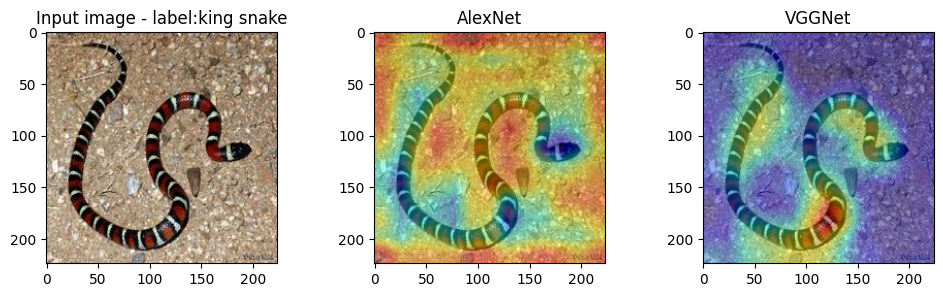

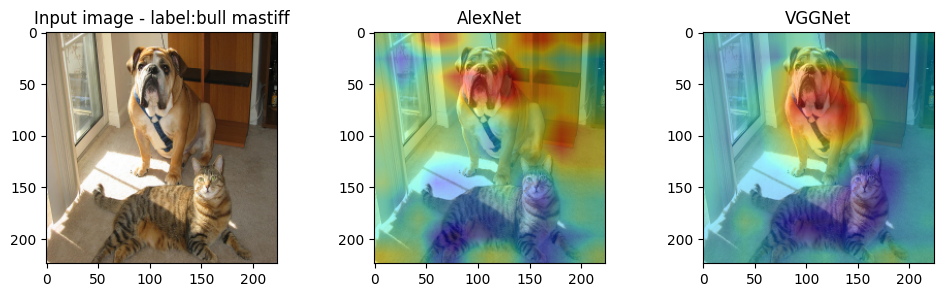

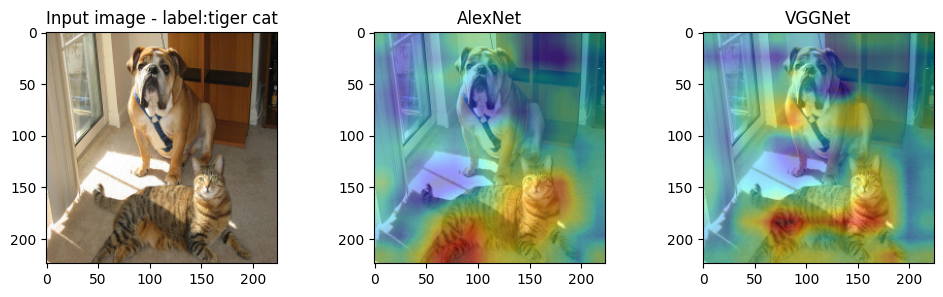

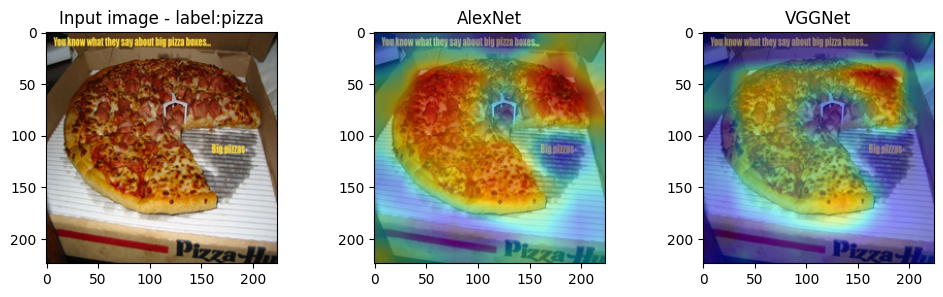

In [30]:
# Instantiation
gradcam_Alex = GradCAM(model_AlexNet)
gradcam_VGG = GradCAM(model_VGGnet)

for i in range(len(test_list)):

    img_path = test_list[i][0]
    target_class = test_list[i][1]

    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)

    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.to(device)

    cam_img_AlexNet = gradcam_Alex.gen_CAM(img, one_hot_target)
    cam_img_VGGNet = gradcam_VGG.gen_CAM(img, one_hot_target)


    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,3,1).set_title('Input image - label:{}'.format(imagenet_class[target_class]))
    plt.imshow(reprocess_image(img))
    fig.add_subplot(1,3,2).set_title('AlexNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_AlexNet, alpha=0.4, cmap='jet')
    fig.add_subplot(1,3,3).set_title('VGGNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_VGGNet, alpha=0.4, cmap='jet')
    plt.show()

### *References*
[1] https://arxiv.org/pdf/1610.02391.pdf <br>
[2] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf <br>
[3] https://arxiv.org/pdf/1409.1556.pdf <br>
[4] https://bob3rdnewbie.tistory.com/320 <br>
[5] https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook <br>
[6] https://arxiv.org/pdf/1412.6806.pdf <br>
[7] https://arxiv.org/pdf/1311.2901.pdf <br>
[8] https://medium.com/@jamesvanneman/paper-club-visualizing-and-understanding-convolutional-networks-629fef9ceb8b <br>